In [25]:
# pip install google-cloud-bigquery

In [26]:
# pip install pandas

In [27]:
# pip install pyarrow

In [ ]:
# pip install google-cloud-bigquery-storage

In [ ]:
# pip install matplotlib

In [ ]:
# pip install tqdm

In [2]:
# BigQuery 라이브러리 import
import os
from google.cloud import bigquery

In [3]:
# project 전역설정
PROJECT = "looker-data-grfit"
# service account json key pair 환경변수 설정
credential_path = "looker-data-grfit-6cd8aea2ca15.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path
# 클라이언트 설정
bq = bigquery.Client(project=PROJECT)

In [4]:
# 데이터셋 조회
dsinfo = bq.get_dataset('pipelining_sample')
print("{} / {} / {}".format(dsinfo.dataset_id, dsinfo.created, dsinfo.location))

pipelining_sample / 2021-11-24 06:35:47.013000+00:00 / asia-northeast3


In [5]:
# 엑세스 권한 조회
for access in dsinfo.access_entries:
    # if access.role == 'READER':
    print(access)

<AccessEntry: role=WRITER, specialGroup=projectWriters>
<AccessEntry: role=OWNER, specialGroup=projectOwners>
<AccessEntry: role=OWNER, userByEmail=jsyoo@vntgcorp.com>
<AccessEntry: role=READER, specialGroup=projectReaders>


In [6]:
# 신규 데이터셋 생성
DS_NAME = "bq_lib_ch05_jsyoo"
dataset_id = "{}.{}".format(PROJECT, DS_NAME)
dsinfo = bigquery.Dataset(dataset_id)
dsinfo.location = "asia-northeast3"
ds = bq.create_dataset(dsinfo, exists_ok=True)

In [7]:
# 데이터셋 삭제
bq.delete_dataset(DS_NAME, not_found_ok=True)

BadRequest: 400 DELETE https://bigquery.googleapis.com/bigquery/v2/projects/looker-data-grfit/datasets/bq_lib_ch05_jsyoo?prettyPrint=false: Dataset looker-data-grfit:bq_lib_ch05_jsyoo is still in use

In [8]:
# 데이터셋 다시 생성
# DS_NAME = "bq_lib_ch05_jsyoo"
dataset_id = "{}.{}".format(PROJECT, DS_NAME)
dsinfo = bigquery.Dataset(dataset_id)
dsinfo.location = "asia-northeast3"
ds = bq.create_dataset(dsinfo, exists_ok=True)

In [11]:
# 신규 테이블 생성
TABLE_NAME = "temp_table"
table_id = "{}.{}.{}".format(PROJECT, DS_NAME, TABLE_NAME)
schema = [
    bigquery.SchemaField("chapter", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("title", "STRING", mode="REQUIRED"),
]
table = bq.create_table(bigquery.Table(table_id, schema), exists_ok=True)

print(table.etag, table.schema)

vms7YcOFl5Uxn6jFPnESoQ== [SchemaField('chapter', 'INTEGER', 'NULLABLE', None, (), None), SchemaField('title', 'STRING', 'NULLABLE', None, (), None)]


In [12]:
# 신규 행 추가
rows = [
    (1, u"What is BigQuery?"),
    (2, u"BigQuery test"),
]

errors = bq.insert_rows(table, rows=rows)

In [13]:
# 테이블 메타데이터는 바로 업데이트 되지 않음
print(table.num_rows)

0


In [14]:
# pandas import
import pandas as pd
from google.cloud.bigquery.job import LoadJobConfig, WriteDisposition, CreateDisposition

In [15]:
# 판다스 데이터 로드
data = [
    (3, u"pandas"),
    (4, u"data load")
]
# 데이터프레임 설정
df = pd.DataFrame(data, columns=["chapter", "title"])
table_id = '{}.{}.{}'.format(PROJECT, DS_NAME, TABLE_NAME)
load_config = LoadJobConfig(
    create_disposition=CreateDisposition.CREATE_IF_NEEDED,
    write_disposition=WriteDisposition.WRITE_APPEND)
# 데이터프레임에서 데이터 로드
job = bq.load_table_from_dataframe(df, table_id, job_config=load_config)
job.result() # blocks and waits

LoadJob<project=looker-data-grfit, location=asia-northeast3, id=89c4c57a-052a-44cb-9814-61225248af0e>

##### LoadJobConfig - Create / Write 설정
1. Create
- CREATE_NEVER : 테이블이 존재한다는 가정하에 작동
- CREATE_IF_NEEDED : 테이블이 있으면 기존 테이블에, 없으면 생성
2. write
- WRITE_APPEND : 데이터 추가
- WRITE_EMPTY : 테이블이 비어있어야 하며, 존재하면 에러발생
- WRITE_TRUNCATE : 기존 테이블을 비우고 데이터 추가


In [16]:
# 로컬파일 로드
with open("upload.csv", mode="rb") as fp:
    job = bq.load_table_from_file(fp, table, job_config=load_config)

In [17]:
# 테이블에서 데이터 추출
# 추출할 table, field, row 정보 설정
table_id = 'bigquery-public-data.london_bicycles.cycle_stations'
table = bq.get_table(table_id)
fields = [field for field in table.schema if 'count' in field.name or field.name =='id']
rows = bq.list_rows(table, start_index=0, max_results=5, selected_fields=fields)
# 추출 데이터 출력
print(*[field.name for field in rows.schema])
for row in rows: print(*row)

id bikes_count docks_count
126 0 52
12 1 49
175 1 51
249 1 42
361 3 55


In [18]:
# 파라미터를 이용한 SQL 실행
sql = open("exec_query.sql").read()
# 쿼리 파라미터 설정
config = bigquery.QueryJobConfig()
config.query_parameters = [
    bigquery.ScalarQueryParameter('min_duration', 'INT64', 600)
]
# 쿼리 실행
result = bq.query(sql, location='EU', job_config=config)
# 쿼리 결과 출력
for row in result:
    fields = (row['start_station_name'], row['num_trips'])
    print(*fields)

Hyde Park Corner, Hyde Park 203592
Belgrove Street , King's Cross 168110
Waterloo Station 3, Waterloo 148809
Albert Gate, Hyde Park 145794
Black Lion Gate, Kensington Gardens 137930
Waterloo Station 1, Waterloo 106092
Wellington Arch, Hyde Park 102770
Triangle Car Park, Hyde Park 99368
Wormwood Street, Liverpool Street 82483
Palace Gate, Kensington Gardens 80342


In [19]:
# jupyter-lab에서 jupyter magic 키워드 사용 개발(%, %%)
# 클라이언트 라이브러리에서 bigquery magic 라이브러리 호출
%load_ext google.cloud.bigquery

In [22]:
%%bigquery df
--project looker-grfit-data
WITH ALL_BAD_TRIPS AS (
    SELECT
        START_STATION_NAME,
        COUNTIF(DURATION < 600 AND START_STATION_NAME = END_STATION_NAME) AS BAD_TRIPS,
        COUNT(*) AS NUM_TRIPS
    FROM `bigquery-public-data`.london_bicycles.cycle_hire
    WHERE EXTRACT(YEAR FROM START_DATE) = 2016
    GROUP BY START_STATION_NAME
    HAVING NUM_TRIPS > 10
)
SELECT *, BAD_TRIPS / NUM_TRIPS AS FRACTION_BAD
FROM ALL_BAD_TRIPS 
ORDER BY FRACTION_BAD DESC

Downloading: 100%|████████████████████████████████████████████████████████████████| 802/802 [00:03<00:00, 231.57rows/s]


In [23]:
df.describe();

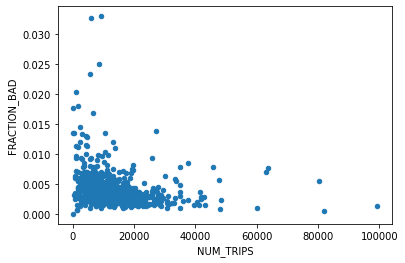

In [24]:
df.plot.scatter('NUM_TRIPS', 'FRACTION_BAD');